<a href="https://colab.research.google.com/github/THANNAGA/predictive_energy_transformer/blob/main/PET_Reconstruction_of_TinyImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/THANNAGA/predictive_energy_transformer.git
from energy_transformer import EnergyTransformer

  Cloning https://github.com/THANNAGA/predictive_energy_transformer.git to /tmp/pip-req-build-8dzik484
  Running command git clone --filter=blob:none --quiet https://github.com/THANNAGA/predictive_energy_transformer.git /tmp/pip-req-build-8dzik484
  Resolved https://github.com/THANNAGA/predictive_energy_transformer.git to commit 34396b0c972782df53bbaab4dc83d57c75ef1c53
  Preparing metadata (setup.py) ... done


In [2]:
GO_CIFAR = True
if GO_CIFAR:
    ## a very long test on image reconstruction (like the original paper)
    import torch
    import torchvision
    import ssl
    import os
    import matplotlib.pyplot as plt
    from einops.layers.torch import Rearrange
    from itertools import chain
    from tqdm import tqdm
    # need this to download the dataset
    ssl._create_default_https_context = ssl._create_unverified_context

    im2tensor = torchvision.transforms.ToTensor()

    def collate(x, im2tensor = im2tensor):
        x = [im2tensor(x_i[0]) for x_i in x]
        return torch.stack(x, dim = 0)

    def tensor2im(x):
        return torchvision.transforms.ToPILImage()(x)

    def save_im(x, path):
        tensor2im(x).save(path)

    def save_features(feature_list, patch_deembedder, depatcher, epoch = 0):
        """Function to save each step in the recurrent iteration of the energy transformer as an image, gives
        a sense of what is actually happening as the energy gradient is surfed."""
        for i, x in enumerate(feature_list):
            x = patch_deembedder(x)
            x = depatcher(x)
            save_im(x[0], f"tmp/epoch_{epoch}_feature_{i}.png")

    if __name__ == "__main__":
        # making a tmp folder to store the images
        os.makedirs("tmp/", exist_ok = True)

        # data root
        data_root = "D:/Projects/" # you should only need to change this

        # data and patcher params
        h, w = 32, 32
        patch_size = 4
        patch_dim = patch_size**2 * 3
        n_patches = 64
        batch_size = 32

        # masking task params
        mask_fraction = 0.5
        mask_dropout = 0.1

        # energy transformer params
        token_dim = 256
        hopfield_hidden_dim = 1024
        n_heads = 8
        n_iters = 2 # number of  reccurent iterations of the energy transformer
        alpha = 0.1 # step size for energy gradient descent

        # training params
        n_epochs = 15
        lr = 1e-3

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        cifar = torchvision.datasets.CIFAR100(root = data_root, train = True, download = True)
        dataloader = torch.utils.data.DataLoader(cifar,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                collate_fn = collate)

        # these break a batch of images into patches and the converse, respectively
        patcher = Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1 = patch_size, p2 = patch_size).to(device)
        depatcher = Rearrange("b (h w) (p1 p2 c) -> b c (h p1) (w p2)", p1 = patch_size, p2 = patch_size, h = h // patch_size, w = w // patch_size).to(device)

        # feedforward layers to convert the last dim of the patched images to an embedding dimension
        patch_embedder = torch.nn.Sequential(
            torch.nn.Linear(patch_dim, token_dim),
            torch.nn.LayerNorm(token_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(token_dim, token_dim)).to(device)
        patch_deembedder = torch.nn.Sequential(
            torch.nn.Linear(token_dim, token_dim),
            torch.nn.LayerNorm(token_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(token_dim, patch_dim)).to(device)

        # token for masking
        mask_token = torch.randn(token_dim).to(device).requires_grad_(True)

        model = EnergyTransformer(token_dim,
                                  hopfield_hidden_dim,
                                  n_heads,
                                  hopfield_type = "softmax",
                                  context = n_patches,
                                  n_iters_default = n_iters,
                                  alpha = alpha,
                                  return_energy = True).to(device)

        # including the embedders, disable them to see how they affect learning (hint: the ET still learns, but slower)
        optimizer = torch.optim.Adam(chain(
                                          model.parameters(),
                                          patch_embedder.parameters(),
                                          patch_deembedder.parameters()
                                          ),
                                        lr = lr)
        criterion = torch.nn.MSELoss()

        # Save the initial model
        checkpoint_path = f"./checkpoint_epoch_0.pth"  # Save in the current directory
        torch.save({
            'epoch': 0,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0
            }, checkpoint_path)

        losses = []
        for epoch in range(n_epochs):
            print(f"Epoch {epoch}")
            for i, x in enumerate(tqdm(dataloader)):
                optimizer.zero_grad()
                x = x.to(device)
                x_orig = x.clone()

                x = patcher(x)
                x = patch_embedder(x)

                # only masked input is in the loss, but a small fraction are left unmasked
                # dropping a few masks is extremely helpful for training (see end of first paragraph in paper appendix A)
                mask_sample = torch.rand(x.shape[0], n_patches)
                mask = mask_sample < mask_fraction
                mask_dropped_out = mask_sample < mask_fraction * (1 - mask_dropout)

                x[mask_dropped_out] = mask_token

                x, features, energies = model(x)
                x = patch_deembedder(x)

                x = depatcher(x)
                # coerce mask shape for deprojection
                mask_vector = mask.unsqueeze(-1).repeat(1, 1, patch_dim)
                img_mask = depatcher(mask_vector)

                # only compute loss on the masked sections
                loss = criterion(x[img_mask], x_orig[img_mask])
                loss.backward()
                optimizer.step()

                losses.append(loss.item())
                """
                if i % 100 == 0:
                    save_im(x_orig[0], f"tmp/epoch_{epoch}_{i}_orig.png")
                    save_im(x[0], f"tmp/epoch_{epoch}_{i}_recon.png")
                    save_features(features, patch_deembedder, depatcher, epoch = epoch)
                """
                # Save model at each epoch
                checkpoint_path = f"./checkpoint_epoch_"+str(epoch+1)+".pth"  # Save in the current directory
                torch.save({
                    'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                    }, checkpoint_path)

100%|██████████| 169001437/169001437 [00:12<00:00, 13191818.12it/s]


Extracting D:/Projects/cifar-100-python.tar.gz to D:/Projects/
Epoch 0


100%|██████████| 1563/1563 [01:17<00:00, 20.17it/s]


Epoch 1


100%|██████████| 1563/1563 [01:15<00:00, 20.63it/s]


Epoch 2


100%|██████████| 1563/1563 [01:16<00:00, 20.33it/s]


Epoch 3


100%|██████████| 1563/1563 [01:15<00:00, 20.72it/s]


Epoch 4


100%|██████████| 1563/1563 [01:14<00:00, 20.84it/s]


Epoch 5


100%|██████████| 1563/1563 [01:16<00:00, 20.49it/s]


Epoch 6


100%|██████████| 1563/1563 [01:14<00:00, 21.07it/s]


Epoch 7


100%|██████████| 1563/1563 [01:16<00:00, 20.36it/s]


Epoch 8


100%|██████████| 1563/1563 [01:13<00:00, 21.33it/s]


Epoch 9


100%|██████████| 1563/1563 [01:13<00:00, 21.40it/s]


Epoch 10


100%|██████████| 1563/1563 [01:13<00:00, 21.29it/s]


Epoch 11


100%|██████████| 1563/1563 [01:12<00:00, 21.57it/s]


Epoch 12


100%|██████████| 1563/1563 [01:12<00:00, 21.47it/s]


Epoch 13


100%|██████████| 1563/1563 [01:13<00:00, 21.15it/s]


Epoch 14


100%|██████████| 1563/1563 [01:13<00:00, 21.15it/s]


In [ ]:
GO_TINY = False
if GO_TINY:

    !pip install tinyimagenet

    from tinyimagenet import TinyImageNet
    from pathlib import Path
    import logging

    logging.basicConfig(level=logging.INFO)

    split ="val"
    dataset = TinyImageNet(Path("~/.torchvision/tinyimagenet/"),split=split)
    n = len(dataset)
    print(f"TinyImageNet, split {split}, has  {n} samples.")
    n_samples = 5
    #print(f"Showing info of {n_samples} samples...")
    for i in range(0,n,n//n_samples):
        image,klass = dataset[i]
        #print(f"Sample of class {klass:3d}, image {image}, words {dataset.idx_to_words[klass]}")

In [ ]:
GO_TINY = False
if GO_TINY:

    ## Let's try to adapt ET to TinyImageNet

    import torch
    import torchvision
    from torch.utils.data import Dataset, DataLoader
    from tinyimagenet import TinyImageNet
    import ssl
    import os
    import matplotlib.pyplot as plt
    from einops.layers.torch import Rearrange
    from itertools import chain
    from tqdm import tqdm
    from pathlib import Path
    # need this to download the dataset
    ssl._create_default_https_context = ssl._create_unverified_context

    from energy_transformer import EnergyTransformer

    im2tensor = torchvision.transforms.ToTensor()

    def collate(x, im2tensor = im2tensor):
        x = [im2tensor(x_i[0]) for x_i in x]
        return torch.stack(x, dim = 0)

    def tensor2im(x):
        return torchvision.transforms.ToPILImage()(x)

    def save_im(x, path):
        tensor2im(x).save(path)

    def save_features(feature_list, patch_deembedder, depatcher, epoch = 0):
        """Function to save each step in the recurrent iteration of the energy transformer as an image, gives
        a sense of what is actually happening as the energy gradient is surfed."""
        for i, x in enumerate(feature_list):
            x = patch_deembedder(x)
            x = depatcher(x)
            save_im(x[0], f"tmp/epoch_{epoch}_feature_{i}.png")

    class TImageNet(Dataset):
        def __init__(self, dataset):
            self.dataset = dataset

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            image, label = self.dataset[idx]
            #image = grayscale_tensor(image)
            return image, label

    if __name__ == "__main__":
        # making a tmp folder to store the images
        os.makedirs("tmp/", exist_ok = True)

        # data root
        data_root = "D:/Projects/" # you should only need to change this

        # data and patcher params
        h, w = 64, 64
        patch_size = 8
        patch_dim = patch_size**2 * 3
        n_patches = 64
        batch_size = 32

        # masking task params
        mask_fraction = 0.3#0.5
        mask_dropout = 0.1

        # energy transformer params
        token_dim = 256
        hopfield_hidden_dim = 1024
        n_heads = 16#8
        n_iters = 12 # number of  reccurent iterations of the energy transformer
        alpha = 0.1 # step size for energy gradient descent

        # training params
        n_epochs = 2
        lr = 1e-5

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load TinyImageNet dataset, train & test
        dataset = TinyImageNet(Path("~/.torchvision/tinyimagenet/"), split="train")
        test_dataset = TinyImageNet(Path("~/.torchvision/tinyimagenet/"), split="val")

        # Create masked train and test datasets
        train_dataset = TImageNet(dataset)
        test_dataset = TImageNet(test_dataset)

        # Create DataLoader
        dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # these break a batch of images into patches and the converse, respectively
        patcher = Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1 = patch_size, p2 = patch_size).to(device)
        depatcher = Rearrange("b (h w) (p1 p2 c) -> b c (h p1) (w p2)", p1 = patch_size, p2 = patch_size, h = h // patch_size, w = w // patch_size).to(device)

        # feedforward layers to convert the last dim of the patched images to an embedding dimension
        patch_embedder = torch.nn.Sequential(
            torch.nn.Linear(patch_dim, token_dim),
            torch.nn.LayerNorm(token_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(token_dim, token_dim)).to(device)
        patch_deembedder = torch.nn.Sequential(
            torch.nn.Linear(token_dim, token_dim),
            torch.nn.LayerNorm(token_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(token_dim, patch_dim)).to(device)

        # token for masking
        mask_token = torch.randn(token_dim).to(device).requires_grad_(True)

        model = EnergyTransformer(token_dim,
                                  hopfield_hidden_dim,
                                  n_heads,
                                  hopfield_type = "softmax",
                                  context = n_patches,
                                  n_iters_default = n_iters,
                                  alpha = alpha,
                                  return_energy = True).to(device)

        num_params = sum(p.numel() for p in model.parameters())
        print("Number of parameters in model:", num_params)

        # including the embedders, disable them to see how they affect learning (hint: the ET still learns, but slower)
        optimizer = torch.optim.Adam(chain(
                                          model.parameters(),
                                          patch_embedder.parameters(),
                                          patch_deembedder.parameters()
                                          ),
                                        lr = lr)
        criterion = torch.nn.MSELoss()

        # Save the initial model
        checkpoint_path = f"./checkpoint_epoch_0.pth"  # Save in the current directory
        torch.save({
            'epoch': 0,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0
            }, checkpoint_path)

        losses = []
        for epoch in range(n_epochs):
            print(f"Epoch {epoch}")
            if epoch > 0:
              print ('loss', loss.item())
            for i, (x, y) in enumerate(tqdm(dataloader)):
                #print ('x.shape', x.shape)
                optimizer.zero_grad()
                x = x.to(device)
                x_orig = x.clone()

                x = patcher(x)
                x = patch_embedder(x)

                #print ('x.shape', x.shape)
                # only masked input is in the loss, but a small fraction are left unmasked
                # dropping a few masks is extremely helpful for training (see end of first paragraph in paper appendix A)
                mask_sample = torch.rand(x.shape[0], n_patches)
                mask = mask_sample < mask_fraction
                mask_dropped_out = mask_sample < mask_fraction * (1 - mask_dropout)

                x[mask_dropped_out] = mask_token

                x, features, energies = model(x)
                x = patch_deembedder(x)

                x = depatcher(x)
                # coerce mask shape for deprojection
                mask_vector = mask.unsqueeze(-1).repeat(1, 1, patch_dim)
                img_mask = depatcher(mask_vector)

                # only compute loss on the masked sections
                loss = criterion(x[img_mask], x_orig[img_mask])
                loss.backward()
                optimizer.step()

                losses.append(loss.item())

                if i % 100 == 0:
                    save_im(x_orig[0], f"tmp/epoch_{epoch+1}_{i}_orig.png")
                    save_im(x[0], f"tmp/epoch_{epoch+1}_{i}_recon.png")
                    save_features(features, patch_deembedder, depatcher, epoch = epoch)
            # Save model at each epoch
            checkpoint_path = f"./checkpoint_epoch_"+str(epoch+1)+".pth"  # Save in the current directory
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
                }, checkpoint_path)

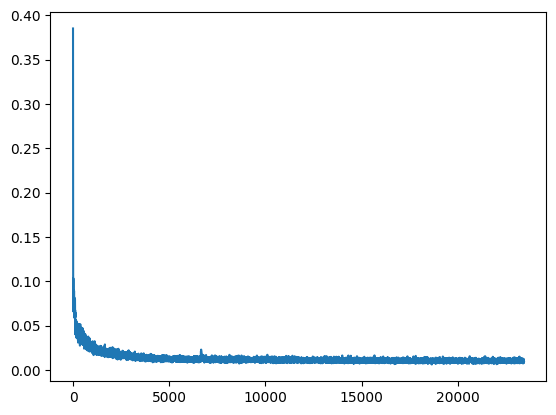

In [ ]:
plt.plot(losses);plt.show()

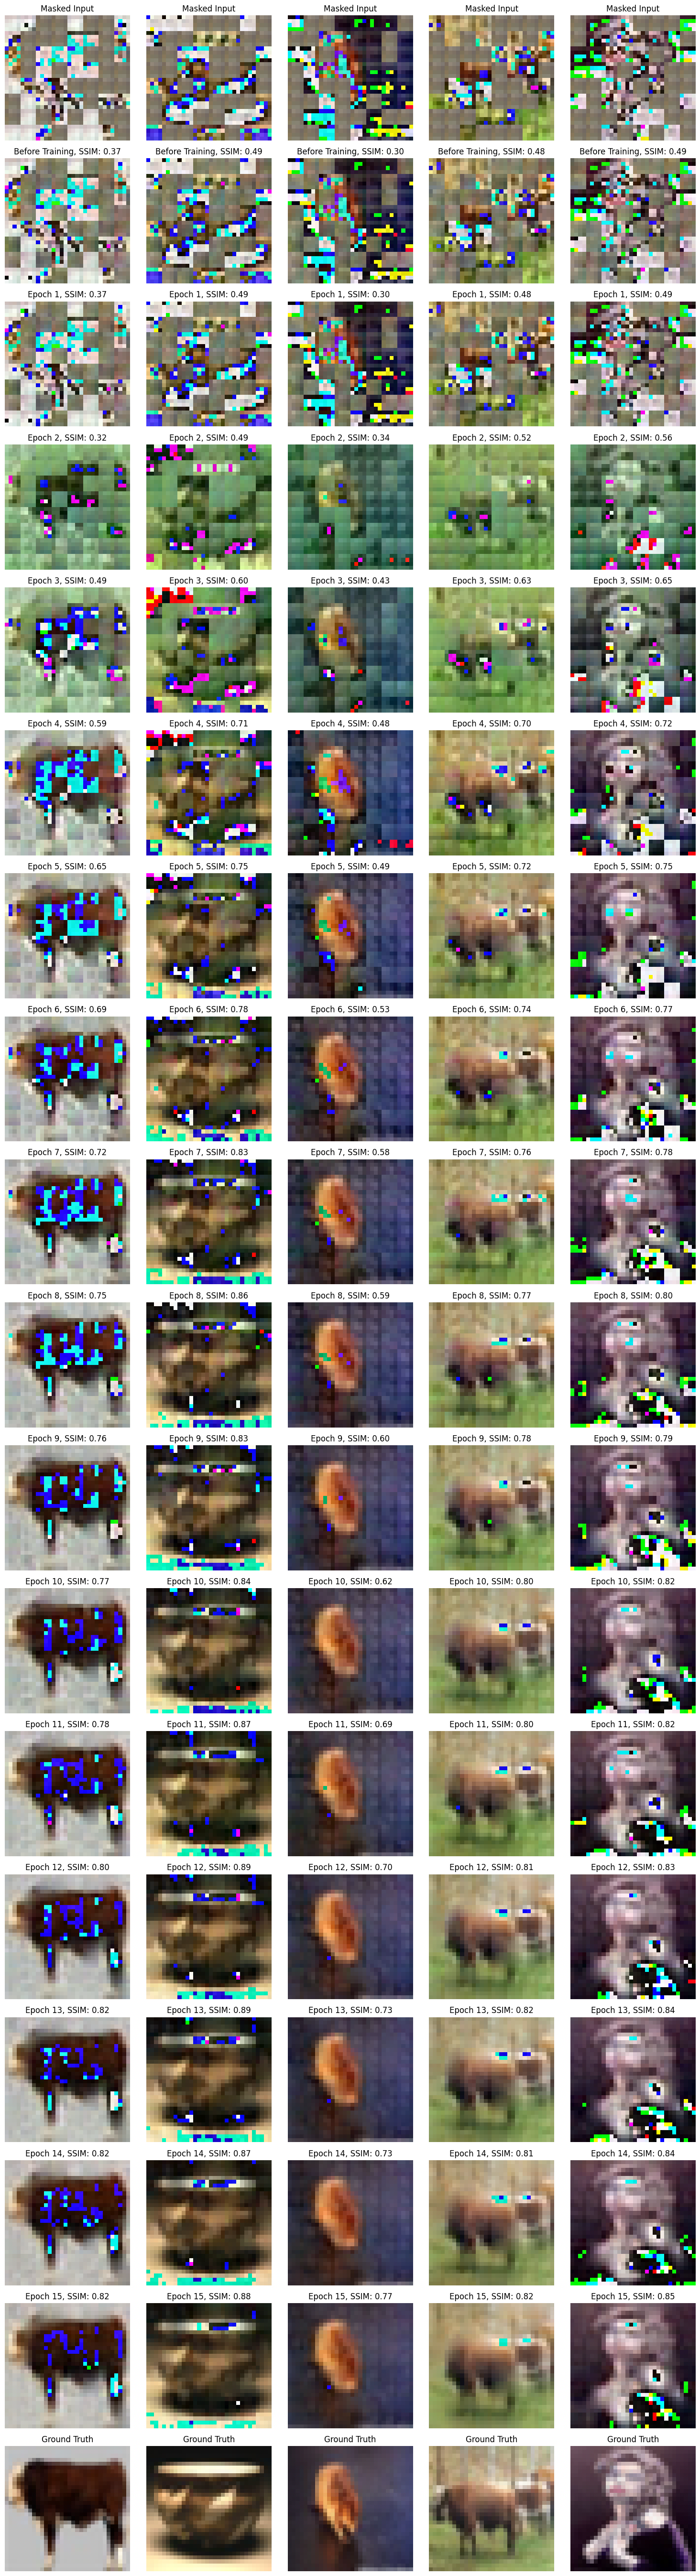

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from einops.layers.torch import Rearrange
from pathlib import Path
from skimage.metrics import structural_similarity as ssim


# Assuming the following variables are defined as in your original code:
# patcher, depatcher, patch_embedder, patch_deembedder, mask_token, device, n_patches, mask_fraction, mask_dropout

# Load a batch of images (replace with your actual data loading)
if GO_CIFAR:
    x = next(iter(dataloader))

if GO_TINY:
    x, _ = next(iter(dataloader))
x = x.to(device)
x_orig = x.clone()

# Create mask
mask_sample = torch.rand(x.shape[0], n_patches)
mask = mask_sample < mask_fraction
mask_dropped_out = mask_sample < mask_fraction * (1 - mask_dropout)

# Mask the input
x_masked = patcher(x)
x_masked = patch_embedder(x_masked)
x_masked[mask_dropped_out, :] = mask_token

# Function to load a model and reconstruct the masked input
def reconstruct(model_path, x_masked):
    model = EnergyTransformer(token_dim,
                              hopfield_hidden_dim,
                              n_heads,
                              hopfield_type = "softmax",
                              context = n_patches,
                              n_iters_default = n_iters,
                              alpha = alpha,
                              return_energy = True).to(device)
    # Load the saved checkpoint
    checkpoint = torch.load(model_path)

    # Extract the model state dictionary from the checkpoint
    model_state_dict = checkpoint['model_state_dict']

    # Load the state dictionary into the model
    model.load_state_dict(model_state_dict)
    model.eval()

    ssim_values = []
    with torch.no_grad():
        x_recon, _, _ = model(x_masked)
        x_recon = patch_deembedder(x_recon)
        x_recon = depatcher(x_recon)
        for j in range(x_recon.shape[0]):
            # Convert tensors to numpy arrays and grayscale
            img1 = x_recon[j].cpu().numpy().transpose(1, 2, 0)
            img2 = x_orig[j].cpu().numpy().transpose(1, 2, 0)
            if img1.shape[-1] == 3:  # Convert to grayscale if necessary
                img1 = img1.mean(axis=-1)
                img2 = img2.mean(axis=-1)
            ssim_val = ssim(img1, img2, data_range=img1.max() - img1.min())
            ssim_values.append(ssim_val)
    return x_recon, ssim_values

# Paths to saved models (replace with your actual paths)
model_paths = [f"./checkpoint_epoch_"+str(i)+".pth" for i in range(n_epochs+1)]

# Create plot
fig, axes = plt.subplots(n_epochs + 3, 5, figsize=(15, 3 * (n_epochs + 3)))

# Plot masked input (depatch and deembed before plotting)
for j in range(5):
    x_masked_image = depatcher(patch_deembedder(x_masked[j:j+1]))  # Deembed and depatch single image
    axes[0, j].imshow(tensor2im(x_masked_image[0]))  # Extract the image from the batch
    axes[0, j].set_title("Masked Input")
    axes[0, j].axis('off')

# Plot reconstruction before training (epoch 0)
x_recon_init, ssim_values = reconstruct(model_paths[0], x_masked)  # Assuming the first model is the untrained one
for j in range(5):
    axes[1, j].imshow(tensor2im(x_recon_init[j]))
    ssim_str = f"{ssim_values[j]:.2f}"  # Truncate SSIM to 2 decimals
    axes[1, j].set_title(f"Before Training, SSIM: {ssim_str}")
    axes[1, j].axis('off')

# Plot reconstructions at different epochs
for i, model_path in enumerate(model_paths):
    x_recon, ssim_values = reconstruct(model_path, x_masked)
    for j in range(5):
        axes[i + 2, j].imshow(tensor2im(x_recon[j]))
        ssim_str = f"{ssim_values[j]:.2f}"  # Truncate SSIM to 2 decimals
        axes[i + 2, j].set_title(f"Epoch {i+1}, SSIM: {ssim_str}")
        axes[i + 2, j].axis('off')

# Plot ground truth
for j in range(5):
    axes[-1, j].imshow(tensor2im(x_orig[j]))
    axes[-1, j].set_title("Ground Truth")
    axes[-1, j].axis('off')

plt.tight_layout()
plt.show()